In [115]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler

<div style="background-color: #E74C3C; padding: 10px">
<font color = "#EBF5FB">

### 2. DATA PREPARATION
</font>
</div>

<font color = "#E74C3C"> 2.1 |</font><font color = "#EBF5FB"> Loading the dataset</font>
<font size = 3>
- The info(), describe() are the first things we might want to inspect having a pandas dataframe; showing feature names, stats and the first few columns to get some initial impression of the data.
- After gathering some insights about the statistical descriptions of predictors and the general structure and data types of the dataframe, we can proceed further with our analysis.
</font>

In [147]:
data = pd.read_csv("Customer Churn\\WA_Fn-UseC_-Telco-Customer-Churn.csv", index_col='customerID')


In [117]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null 

In [118]:
data.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [119]:
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


<font size = 3>

- Upon inspection, it turns out that `TotalCharges` needs to be converted to float, currently its dtype is `object`

</font>

In [148]:
data.TotalCharges = pd.to_numeric(data.TotalCharges, errors='coerce')   # Coerce will set invalid parsings as NaN

In [149]:
data.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

<font size = 3>

- Many columns have a repeating value "No internet service".
- A new predictor variable called `Internet Service` can be created.
- This will ease the encoding process for these columns and reduce data redundancy.
- The 'No internet sevice' cell value will be replaced with 'No'.

<font color = "yellow">
[!] Only the rows where all the relevant columns contain 'No internet service' are modified.
</font>
</font>

In [150]:
# Creating mask to identify rows with the value 'No internet service'
intServiceColumns = ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']
intServiceMask = (data[intServiceColumns] == 'No internet service').all(axis=1)

# Creating a new column 'InternetService' and assigning appropriate values
data['InternetService'] = 1
data.loc[intServiceMask, 'InternetService'] = 0

# Change the values from 'No internet service' to 'No'
data.loc[intServiceMask, intServiceColumns] = 'No'

<font size = 3>

- The column `MultipleLines` contains three values: Yes, No and No Phone Service.
- The data already has a column `PhoneService` that contains information about Phone Service.
- The 'Phone Service' label in the MultipleLines column can safely be replaced with 'No'.

</font>

In [151]:
data.loc[data['MultipleLines'] == 'No phone service','MultipleLines'] = 'No'

<font color = "#E74C3C"> 2.2 |</font><font color = "#EBF5FB"> Data Imputation</font>
<font size = 3>
- 'TotalCharges' contains 11 missing values.
- Some models do not tolerate missing values, so data imputation is required on the dataset.
</font>

In [152]:
imp = SimpleImputer(strategy='median')
data.TotalCharges = imp.fit_transform(data[['TotalCharges']])

<font color = "#E74C3C"> 2.3 |</font><font color = "#EBF5FB"> Converting Categorical Features into Numeric Features and Scaling Features</font>
<font size = 3>
- We need to convert the categorical features like Partner, Dependents to numerical features.
    - We will use `OneHotEncoder` for this conversion.
- The label also needs to be converted to 1 and 0.
    - We will use `OrdinalEncoder` for this conversion.
- We need to use Standard Scaler on columns like Tenure and Charges.
- We will create a `ColumnTransformer` to apply suitable conversion to each column.
</font>

In [153]:
# Checking the number of unique values in each column to understand
# which encoder should they be fed to.
data.nunique()

gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          2
InternetService        2
OnlineSecurity         2
OnlineBackup           2
DeviceProtection       2
TechSupport            2
StreamingTV            2
StreamingMovies        2
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

In [154]:

uniqueCountByColumn = data.nunique()
ordinalColumns = uniqueCountByColumn[uniqueCountByColumn == 2].index.tolist()
oneHotColumns = uniqueCountByColumn[uniqueCountByColumn.between(3,5)].index.tolist()
scaleColumns = ['tenure','TotalCharges','MonthlyCharges']

In [155]:
ohe = OneHotEncoder(sparse_output=False)
ode = OrdinalEncoder()
stdScaler = StandardScaler()
colTransformer = make_column_transformer(
    (ode, ordinalColumns),
    (ohe, oneHotColumns),
    (stdScaler,scaleColumns),
    remainder= 'passthrough'
)
colTransformer.set_output(transform = 'pandas')

ColumnTransformer(remainder='passthrough',
                  transformers=[('ordinalencoder', OrdinalEncoder(),
                                 ['gender', 'SeniorCitizen', 'Partner',
                                  'Dependents', 'PhoneService', 'MultipleLines',
                                  'InternetService', 'OnlineSecurity',
                                  'OnlineBackup', 'DeviceProtection',
                                  'TechSupport', 'StreamingTV',
                                  'StreamingMovies', 'PaperlessBilling',
                                  'Churn']),
                                ('onehotencoder',
                                 OneHotEncoder(sparse_output=False),
                                 ['Contract', 'PaymentMethod']),
                                ('standardscaler', StandardScaler(),
                                 ['tenure', 'TotalCharges', 'MonthlyCharges'])])

In [156]:
encodedData = colTransformer.fit_transform(data)

In [157]:
# Column transformer changes the names of columns in the data.
# Changing the names of columns back to original state. 
originalColNames = []
for i,colName in enumerate(encodedData.columns):
    originalName = colName.split('__')[-1]
    originalColNames.append(originalName)
    
encodedData.columns = originalColNames

<font color = "#F86D6E">

Taking a final look at the description of data to ensure all the steps produced the correct output:

</font>

In [158]:
encodedData.nunique()


gender                                        2
SeniorCitizen                                 2
Partner                                       2
Dependents                                    2
PhoneService                                  2
MultipleLines                                 2
InternetService                               2
OnlineSecurity                                2
OnlineBackup                                  2
DeviceProtection                              2
TechSupport                                   2
StreamingTV                                   2
StreamingMovies                               2
PaperlessBilling                              2
Churn                                         2
Contract_Month-to-month                       2
Contract_One year                             2
Contract_Two year                             2
PaymentMethod_Bank transfer (automatic)       2
PaymentMethod_Credit card (automatic)         2
PaymentMethod_Electronic check          

In [159]:
encodedData.isnull().sum()

gender                                     0
SeniorCitizen                              0
Partner                                    0
Dependents                                 0
PhoneService                               0
MultipleLines                              0
InternetService                            0
OnlineSecurity                             0
OnlineBackup                               0
DeviceProtection                           0
TechSupport                                0
StreamingTV                                0
StreamingMovies                            0
PaperlessBilling                           0
Churn                                      0
Contract_Month-to-month                    0
Contract_One year                          0
Contract_Two year                          0
PaymentMethod_Bank transfer (automatic)    0
PaymentMethod_Credit card (automatic)      0
PaymentMethod_Electronic check             0
PaymentMethod_Mailed check                 0
tenure    

In [160]:
encodedData.dtypes

gender                                     float64
SeniorCitizen                              float64
Partner                                    float64
Dependents                                 float64
PhoneService                               float64
MultipleLines                              float64
InternetService                            float64
OnlineSecurity                             float64
OnlineBackup                               float64
DeviceProtection                           float64
TechSupport                                float64
StreamingTV                                float64
StreamingMovies                            float64
PaperlessBilling                           float64
Churn                                      float64
Contract_Month-to-month                    float64
Contract_One year                          float64
Contract_Two year                          float64
PaymentMethod_Bank transfer (automatic)    float64
PaymentMethod_Credit card (auto

<font color = "#E74C3C"> 2.4 |</font><font color = "#EBF5FB"> Splitting the data into train & test set</font>
<font size = 3>
- We want to reserve some data to see how good the model is at predicting data which was not seen earlier in training phase.
- `trdata` : Training data subset
- `tedata` : Test data subset
</font>

In [162]:
trdata, tedata = train_test_split(encodedData, test_size=0.3)

<div style="background-color: #E74C3C; padding: 10px">
<font color = "#EBF5FB">

### 3. EXPLORATORY DATA ANALYSIS
</font>
</div>

<font color = "#E74C3C"> 3.1 |</font><font color = "#EBF5FB"> Univariate histograms</font>
<font size = 3>
Let's start by exploring the distribution of numeric predictors, using `univariate analysis`. What we might look for in the histograms:

- Data distribution (is the data skewed or symmetrically distributed?)
- Outliers (Some models are very sensitive to outliers)
- Patterns in data (Data abnormalities can also affect model performance)
</font>


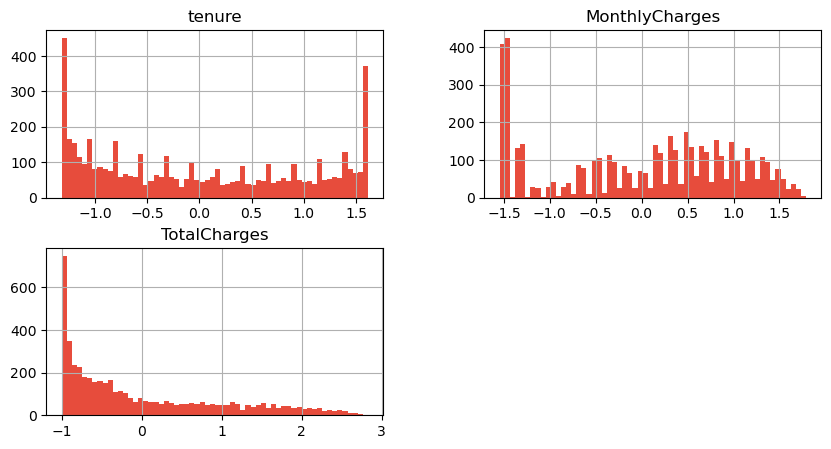

In [163]:
trdata[['tenure','MonthlyCharges','TotalCharges']].hist(bins=60, figsize=(10,5), color="#E74C3C")
plt.show()

<font color = "#E74C3C"> Outliers </font>
<font size = 3>
- Our numeric predictors do not contain any noticeable outliers. Sharp peaks at the beginning of histograms <br> indicate that a huge chunk of customers have
 tenure less than 5 months and monthly charges ~ 20
</font>

<br>

<font color = "#E74C3C"> 3.2 |</font><font color = "#EBF5FB"> Bivariate correlation matrix</font>
<font size = 3>
- Correlation matrix contains only the information about the linear similarity of two feature relations.

What are we looking for?
- Highly correlated features can be dropped.
- High correlation between multiple features could indicate that features may represent similar things.
</font>

In [164]:
# Function to plot the correlation of features
def corrMat(df):
    corr_mat = df.corr().round(2)
    f, ax = plt.subplots(figsize=(13,13))
    mask = np.zeros_like(corr_mat,dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr_mat, vmin=-1, vmax=1, center=0,
                cmap='plasma',square = True,annot=True, cbar = False, lw = 1)
    plt.show()

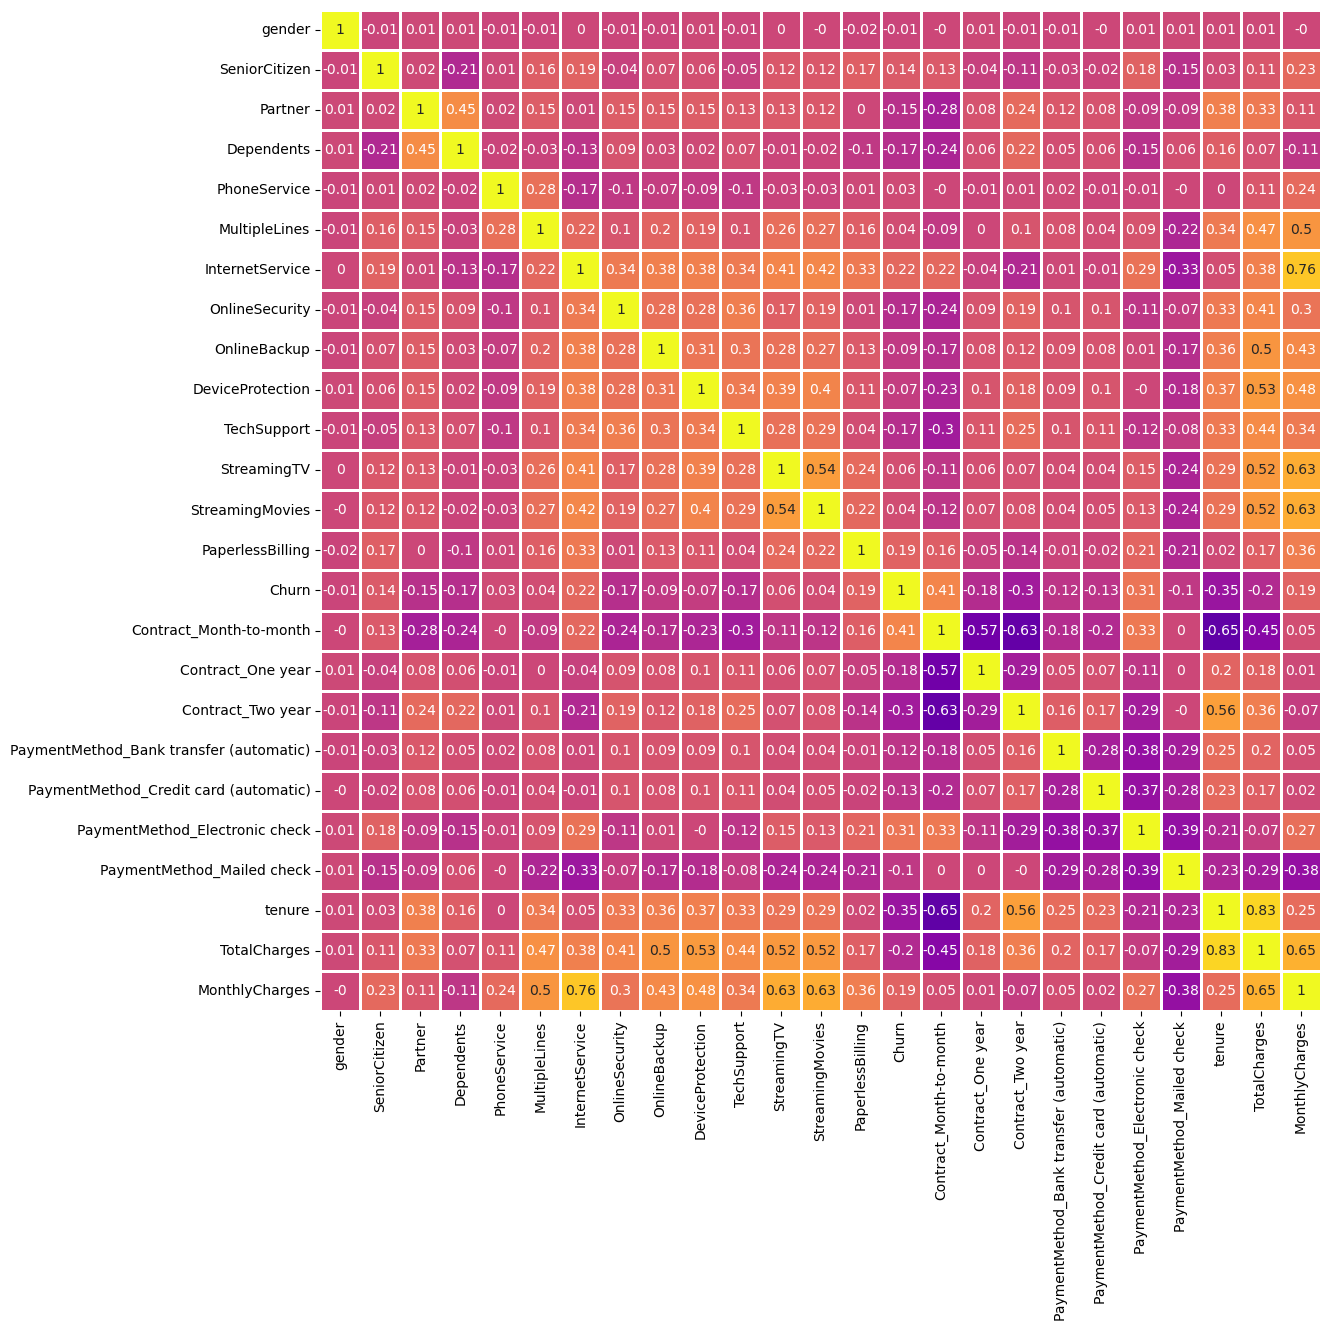

In [165]:
corrMat(trdata)#[['tenure','MonthlyCharges','TotalCharges','Churn']]) # plot masked numpy correlation matrix

- From the correlation heatmap, it is evident that Tenure and TotalCharges are highly correlated, so we can drop either one.
- The correlation of `Tenure` is greater than the correlation of `Total Charges` w.r.t. `Churn`, so we can choose to drop TotalCharges.
- `Internet Service` and `Monthly Charges` are also highly correlated, and they show almost equal correlation with `Churn`, so we can drop either one.
- `Streaming Movies` and `Streaming TV` are also highly correlated with `Monthly Charges`, and they are not correlated to `Churn` at all, so these can also be dropped.

In [166]:
trdata.drop(['TotalCharges','InternetService','StreamingMovies','StreamingTV'],axis=1, inplace=True)

In [167]:
tedata.drop(['TotalCharges','InternetService','StreamingMovies','StreamingTV'],axis=1, inplace=True)

<div style="background-color: #E74C3C; padding: 10px">
<font color = "#EBF5FB">

### 4. MODEL TRAINING AND TESTING
</font>
</div>

In [168]:
from sklearn.model_selection import KFold, cross_val_score

def train_and_evaluate(clf, trdata, tedata, k):
    clf.fit(trdata.drop(['Churn'],axis=1),trdata['Churn'])
    print ("Training set score: ",clf.score(trdata.drop(['Churn'],axis=1),trdata['Churn']))
    cv = KFold(k)
    scores = cross_val_score(clf,tedata.drop(['Churn'],axis=1),tedata['Churn'], cv=cv)
    print('Mean score: ',np.mean(scores)) 


In [253]:
from sklearn.svm import SVC
clf = SVC(kernel='linear')

train_and_evaluate(clf, trdata, tedata, 10)

Training set score:  0.8004056795131845
Mean score:  0.812590539211303
